# Create a surrogate model for the objective function for the three survey line example

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [3]:
import pickle
import numpy
import matplotlib.pyplot as plt
import cofi
import smt
import smt.sampling_methods
import smt.surrogate_models 
import smt.utils.misc
import tqdm
from forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper
)

numpy.random.seed(42)
numpy.set_printoptions()

# Background

This example use the surrogate modelling toolbox to create a surrogate model for the objective function used in the synthetic [example](./three_survey_lines.ipynb) where we invert the vertical component of three survey lines of a VTEM max survey. This notebook employs the  [Kriging approach](https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/gpr/krg.html) using the training and test samples generated [here](three_survey_lines_latin_hypercube_sampling.ipynb) to create a surrogate model.


In [4]:
with open('three_survey_lines_lhs.npy', 'rb') as f:
    ndim=int(numpy.load(f))
    xlimits=numpy.load(f) 
    xtrain=numpy.load(f)
    ytrain=numpy.load(f)
    xtest=numpy.load(f)
    ytest=numpy.load(f)

xlimits=xlimits.astype('double')
xtrain=xtrain[0:100].astype('double')
ytrain=ytrain[0:100].astype('double')
xtest=xtest[0:10].astype('double')
ytest=ytest[0:10].astype('double')

### Training the surrogate model

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 24.3445399
Kriging,  err: 0.06439505506845007


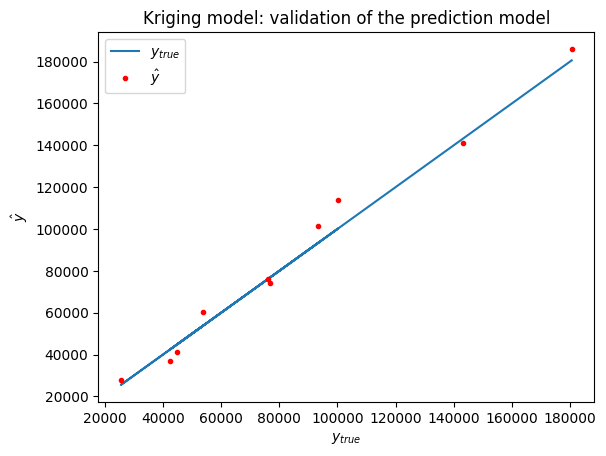

theta values [0.06047011 0.09237428 0.00336048 0.0136285  0.03679849]


In [5]:
########### The Kriging model

# The variable 'theta0' is a list of length ndim.
t = smt.surrogate_models.KRG(theta0=[1e-2]*ndim,print_prediction = False)
t.set_training_values(xtrain,ytrain)
t.train()
# Prediction of the validation points
y = t.predict_values(xtest)
print('Kriging,  err: '+ str(smt.utils.misc.compute_rms_error(t,xtest,ytest)))
# pot the function and the prediction
fig = plt.figure()
plt.plot(ytest, ytest, '-', label='$y_{true}$')
plt.plot(ytest, y, 'r.', label='$\\hat{y}$')   
plt.xlabel('$y_{true}$')
plt.ylabel('$\\hat{y}$')
plt.legend(loc='upper left')
plt.title('Kriging model: validation of the prediction model')
plt.show()
# Value of theta
print("theta values",  t.optimal_theta)

### Testing the surrogate model

The independed set of test samples allows to validate the ability of the surrogate model to predict the true response.

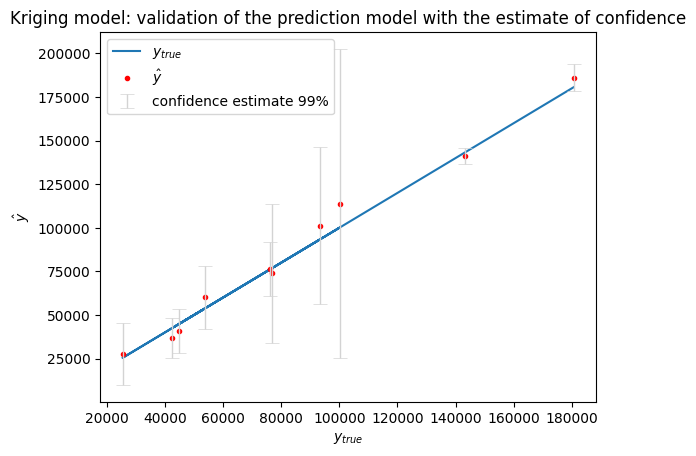

In [6]:
# estimated variance for the validation points
s2 = t.predict_variances(xtest)
#plot with the associated interval confidence
yerr= 2*3*numpy.sqrt(s2) #in order to use +/- 3 x standard deviation: 99% confidence interval estimation

# Plot the function, the prediction and the 99% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(ytest, ytest, '-', label='$y_{true}$')
plt.plot(ytest, y, 'r.', label='$\\hat{y}$')
plt.errorbar(numpy.squeeze(ytest), numpy.squeeze(y), yerr=numpy.squeeze(yerr), fmt = 'none', capsize = 5, ecolor = 'lightgray', elinewidth = 1, capthick = 0.5, label='confidence estimate 99%')
plt.xlabel('$y_{true}$')
plt.ylabel('$\\hat{y}$')

plt.legend(loc='upper left')
plt.title('Kriging model: validation of the prediction model with the estimate of confidence')   
plt.show()

### Save the surrogate model for subsequent use

In [7]:
filename = "kriging_surrogate_model.pkl"
with open(filename, "wb") as f:
   pickle.dump(t, f)

---
# Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [8]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib","smt"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
smt 2.6.3
